## Project: Traffic Sign Recognition Classifier


Traffic signs are an integral part of our transportation system. They provide critical information for drivers to promote their safety. Establishing a reliable Traffic Sign Classification mechanism is a significant step towards building semi-autonomous/autonomous vehicles. In this project, a deep convolutional neural network is used to classify the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


## Load German Traffic Sign Data

In [1]:
# Load pickled data
import pickle


# Read the dataset

training_file = "./Dataset/train.p"
validation_file="./Dataset/valid.p"
testing_file = "./Dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [2]:
import numpy as np


# Number of training examples
n_train = X_train.shape[0]


# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image
image_shape = X_train.shape[1:3]

# Number of unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of Validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of Validation examples = 4410
Image data shape = (32, 32)
Number of classes = 43


## Visualize the German Traffic Signs Dataset

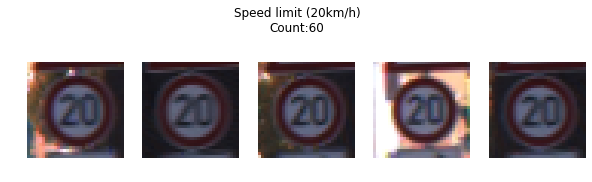

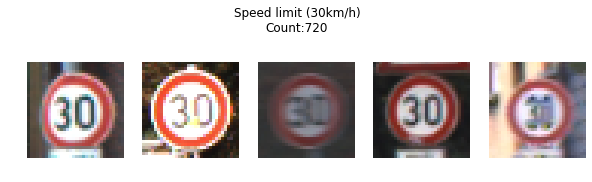

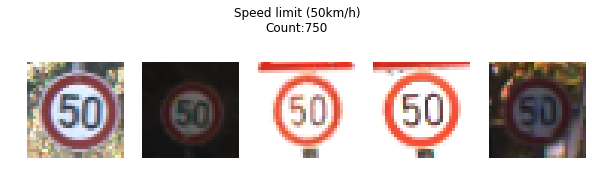

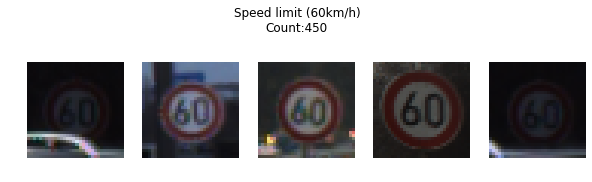

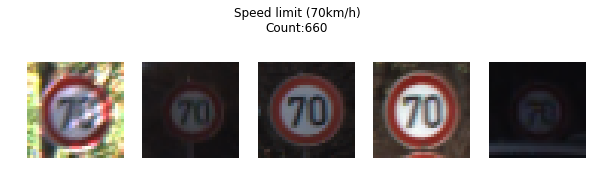

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline


set_to_check = test
X_set, y_set = set_to_check['features'], set_to_check['labels']
csv = pd.read_csv('./Dataset/signnames.csv')

unique_set_data = np.unique(y_set,return_counts=True) 


# Show 5 classes
# Change 5 to other number < 43 to display more classes
num_sign_class_to_display = 5
num_examples_to_plot_per_class = 5



for num_class in range(num_sign_class_to_display):
    
    index = 0
    sub = str(csv['SignName'][num_class]) + "\nCount:" + str(unique_set_data[1][num_class])
    plt.figure(figsize=(10, 3))
    for i in range(y_set.shape[0]):
        if (y_set[i] == num_class):
            plt.subplot(100 + num_examples_to_plot_per_class * 10 +index + 1 )
            image = X_set[i]
            plt.axis("off")
            plt.imshow(image)
            index+=1
            
            if (index == num_examples_to_plot_per_class ):
                break
    plt.suptitle(sub)
    plt.show()
    

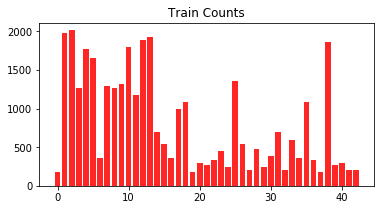

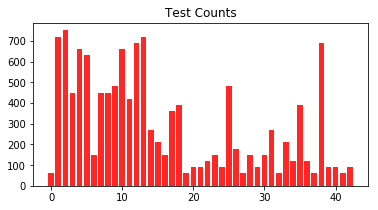

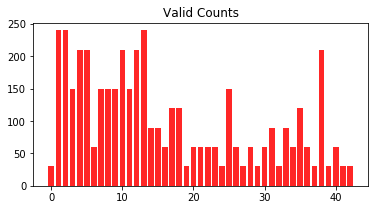

In [4]:
X_unique, X_unique_count = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6, 3))
plt.bar(X_unique, X_unique_count,facecolor='r', alpha=0.85)
plt.title("Train Counts")
plt.show()

plt.figure(figsize=(6, 3))
y_unique, y_unique_count = np.unique(y_test, return_counts=True)
plt.bar(y_unique, y_unique_count,facecolor='r', alpha=0.85)
plt.title("Test Counts")
plt.show()

plt.figure(figsize=(6, 3))
v_unique, v_unique_count = np.unique(y_valid, return_counts=True)
plt.bar(v_unique, v_unique_count,facecolor='r', alpha=0.85)
plt.title("Valid Counts")
plt.show()

----

## Step 2: Design and Test a Model Architecture




### Images before pre-processing

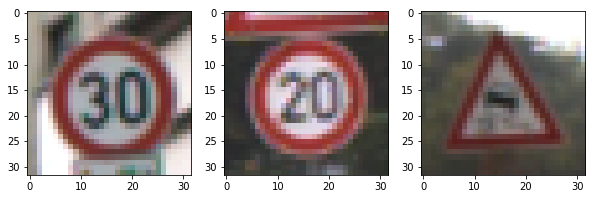

In [5]:
f, axarr = plt.subplots(1,3,figsize=(10, 10))
axarr[0].imshow(X_train[2930])
axarr[1].imshow(X_test[2930])
axarr[2].imshow(X_valid[293]);

In [6]:
import cv2

def grayscale(img):
    YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return np.resize(YCrCb[:,:,0], (32,32,1))

def normalize(img):
    a =-0.5
    b = 0.5
    minimum = 0.0
    maximum = 255.0
    return a + ((img - minimum) * (b - a)) / (maximum - minimum)



def pre_process(images, convert_gray=True):
    imgs = images.copy()
    ret_array = []
    for img in imgs:
        if(convert_gray):
            ret_array.append(normalize(grayscale(img)))
        else:
            ret_array.append(normalize(img))
    return ret_array


X_train = pre_process (X_train)
X_test = pre_process (X_test)
X_valid = pre_process (X_valid)

### Images after pre-processing


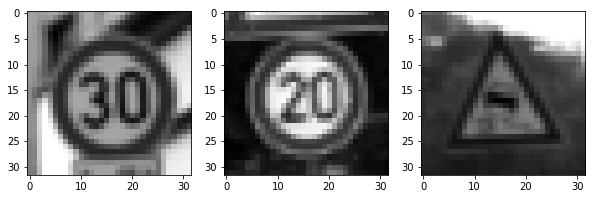

In [7]:
f, axarr = plt.subplots(1,3,figsize=(10, 10))
axarr[0].imshow(X_train[2930].reshape(32,32),cmap='gray')
axarr[1].imshow(X_test[2930].reshape(32,32),cmap='gray')
axarr[2].imshow(X_valid[293].reshape(32,32),cmap='gray');

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

### Model Architecture

In [9]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32],mean = mu, stddev = sigma)),        # Conv1
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64],mean = mu, stddev = sigma)),       # Conv2
    'wfc1': tf.Variable(tf.random_normal([1600, 64],mean = mu, stddev = sigma)),         # fully connected 01
    'wfc2': tf.Variable(tf.random_normal([64,  16],mean = mu, stddev = sigma)),         # fully connected 02    
    'out': tf.Variable(tf.random_normal([16, 43],mean = mu, stddev = sigma))             # Ouput
    }   

    biases = {
    'bc1': tf.Variable(tf.zeros([32])),
    'bc2': tf.Variable(tf.zeros([64])),
    'wfc1': tf.Variable(tf.zeros([64])),
    'wfc2': tf.Variable(tf.zeros([16])),
    'out': tf.Variable(tf.zeros([43]))}   
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    # padding:Valid, strid: 1 -> (32-x+1) = 28, x = 5 filter_size
    
    layer_01 = tf.nn.conv2d(x, weights['wc1'], [1,1,1,1], padding='VALID') 
    layer_01 = tf.nn.bias_add(layer_01,biases['bc1'])  
    
       
    # Activation.
    layer_01 = tf.nn.relu(layer_01)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    layer_01 = tf.nn.max_pool(layer_01, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # Layer 2: Convolutional. Output = 10x10x64.
    layer_02 = tf.nn.conv2d(layer_01, weights['wc2'], [1,1,1,1], padding='VALID') 
    layer_02 = tf.nn.bias_add(layer_02,biases['bc2'])
    
    # Activation.
    layer_02 = tf.nn.relu(layer_02)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    layer_02 = tf.nn.max_pool(layer_02, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # Flatten. Input = 5x5x16. Output = 1600.
    layer_flatten = flatten (layer_02)
    #layer_flatten = tf.nn.dropout(layer_flatten, 0.40) 
    
    # Layer 3: Fully Connected. Input = 1600. Output = 64.
    layer_03 = tf.add(tf.matmul(layer_flatten, weights['wfc1']), biases['wfc1'])
    
    # Activation.
    layer_03 = tf.nn.relu(layer_03)
    #layer_03 = tf.nn.dropout(layer_03, 0.30) 


    # Layer 4: Fully Connected. Input = 64. Output = 16.
    layer_04 = tf.add(tf.matmul(layer_03, weights['wfc2']), biases['wfc2'])
    
    # Activation.
    layer_04 = tf.nn.relu(layer_04)

    # Layer 5: Fully Connected. Input = 16. Output = 43.
    logits = tf.add(tf.matmul(layer_04, weights['out']), biases['out'])
    
    return logits

### Features and Labels

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Training PipeLine

In [12]:
rate = 0.001
EPOCHS = 30
BATCH_SIZE = 60

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Validation

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [14]:
X_validation = X_valid
y_validation = y_valid
errors = []
max_val_accuracy=0
model_saved =""

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("[INFO]  Training...\n")

    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run([training_operation], 
                               feed_dict={x: batch_x, y: batch_y})

        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        errors.append((training_accuracy,validation_accuracy))
        
        if max_val_accuracy < validation_accuracy:
            max_val_accuracy = validation_accuracy
            model_saved = "   Model saved: ./model/lenet "
            saver.save(sess, './model/lenet')
            
            
        print("[INFO]  EPOCH {}/{}  ".format(i + 1, EPOCHS),
              "  train_acc = {:.3f}".format(training_accuracy),
              "  val_acc = {:.3f}".format(validation_accuracy)
             ,model_saved
             )
        model_saved=""
        
    

[INFO]  Training...

[INFO]  EPOCH 1/30     train_acc = 0.880   val_acc = 0.824    Model saved: ./model/lenet 
[INFO]  EPOCH 2/30     train_acc = 0.955   val_acc = 0.910    Model saved: ./model/lenet 
[INFO]  EPOCH 3/30     train_acc = 0.972   val_acc = 0.924    Model saved: ./model/lenet 
[INFO]  EPOCH 4/30     train_acc = 0.975   val_acc = 0.917 
[INFO]  EPOCH 5/30     train_acc = 0.979   val_acc = 0.924 
[INFO]  EPOCH 6/30     train_acc = 0.989   val_acc = 0.923 
[INFO]  EPOCH 7/30     train_acc = 0.985   val_acc = 0.930    Model saved: ./model/lenet 
[INFO]  EPOCH 8/30     train_acc = 0.991   val_acc = 0.934    Model saved: ./model/lenet 
[INFO]  EPOCH 9/30     train_acc = 0.991   val_acc = 0.938    Model saved: ./model/lenet 
[INFO]  EPOCH 10/30     train_acc = 0.995   val_acc = 0.935 
[INFO]  EPOCH 11/30     train_acc = 0.998   val_acc = 0.938 
[INFO]  EPOCH 12/30     train_acc = 0.993   val_acc = 0.930 
[INFO]  EPOCH 13/30     train_acc = 0.995   val_acc = 0.940    Model saved: 

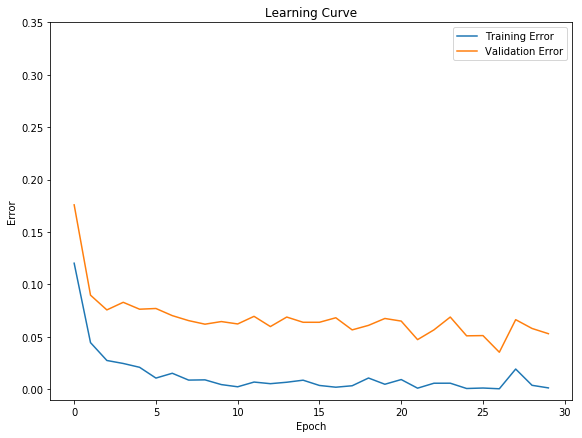

In [15]:
plt.figure(figsize=(8,6))
plt.title('Learning Curve')
plt.plot([1 - el[0] for el in errors])
plt.plot([1 - el[1] for el in errors])
plt.ylim([-.01,0.35])
plt.legend(['Training Error','Validation Error'])
plt.tight_layout()
plt.ylabel('Error')
plt.xlabel('Epoch');

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))

    train_accuracy = evaluate(X_train, y_train)
    print("\n[INFO] Train Accuracy = {:.3f}".format(train_accuracy))

INFO:tensorflow:Restoring parameters from ./model/lenet

[INFO] Train Accuracy = 0.999


## Model Evaluation

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))

    test_accuracy = evaluate(X_test, y_test)
    print("\n[INFO] Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model/lenet

[INFO] Test Accuracy = 0.929


---

## Step 3: Test a Model on New Images


### Load and Output the Images

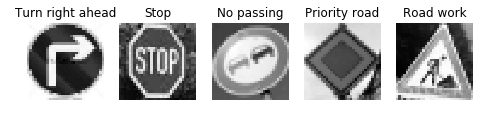

In [18]:
import os
from PIL import Image
img_label = []
img_path = []
new_img_path = './test_img/'
for path, subdirs, files in os.walk(new_img_path):
    for name in files:
        img_list = (os.path.join(path, name))
        img_label.append(img_list.split(new_img_path)[1].split(".")[0])
        img_path.append(img_list)
images = np.array([np.array(Image.open(fname).convert('L')) for fname in img_path])

index = 0
plt.figure(figsize=(8, 2))
for i in range(image.shape[0]):
    axis = plt.subplot(100 + 5 * 10 +index + 1 )
    
    image = images[i]
    plt.axis("off")
    
    plt.imshow(image,cmap='gray')
    sub = str(csv.loc[int(img_label[i]),'SignName'])
    axis.set_title(sub)

    index+=1
    if (index == 5 ):
        break
plt.show()
    
    

### Predict the Sign Type for Each Image

In [19]:
new_images = images.astype(np.float32)
new_images = np.array(pre_process(new_images,convert_gray=False))
new_images = new_images.reshape(new_images.shape[0], 32, 32,1)

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))

    test_accuracy = evaluate(new_images, img_label)
    print("[INFO] Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./model/lenet
[INFO] Test Accuracy = 0.600


In [21]:
Show_TOP = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    top = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=Show_TOP), feed_dict={x:new_images})


INFO:tensorflow:Restoring parameters from ./model/lenet


<Figure size 576x144 with 0 Axes>

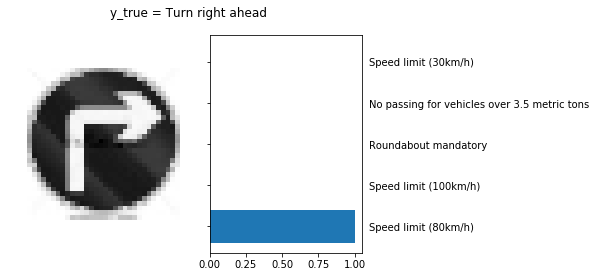

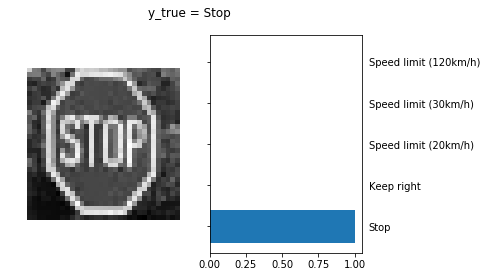

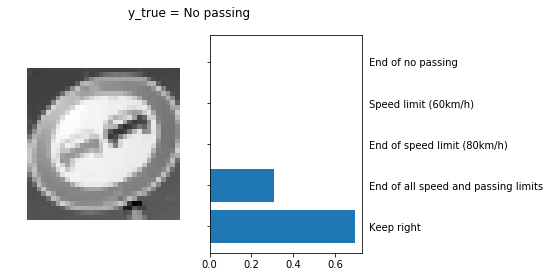

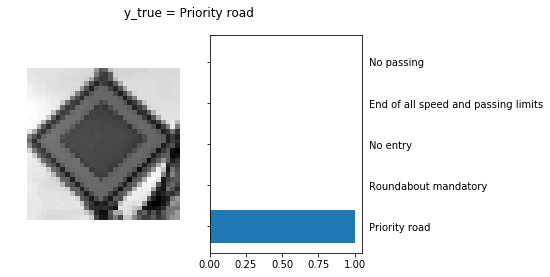

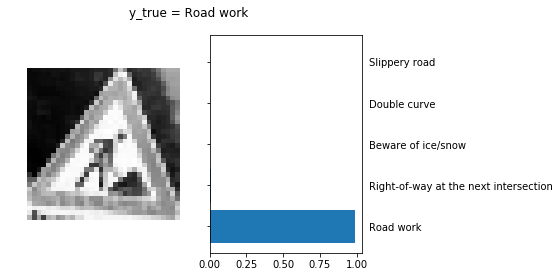

In [22]:
new_images = images.reshape(new_images.shape[0], 32, 32)

plt.figure(figsize=(8, 2))
for i in range(new_images.shape[0]):
    if (i == 5 ):
        break
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.suptitle("y_true = {}".format(str(csv.loc[int(img_label[i]),'SignName'])))
    
    ax1.imshow(new_images[i],cmap='gray')
    ax1.axis("off")
   
    
    ax2.barh(range(Show_TOP), top.values[i], align='center')
    ax2.set_yticks(range(Show_TOP))
    
    #+(csv.loc[top[1][i].astype(int),'SignName'])
    ax2.set_yticklabels( csv.loc[top[1][i].astype(int),'SignName'] )
    ax2.tick_params(labelleft=False , labelright=True)

